# Word Alignment Visualization (Fast Align)

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os
import opennmt
import string
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data and Alignment File
- Cell output:
    - es_data: Spanish BPE applied dataset
    - en_data: English BPE applied dataset
    - align_data: Fast Align Data (*.gdfa)

In [11]:
def read_text(filepath):
    return pd.read_csv(filepath, header=None, names=["content"], sep="\n")

def read_align(filepath):
    return pd.read_csv(filepath, header=None, names=["align"])

def show_data(data, char_show=100, row_show=10, col_show=10, prec_show=6, sample=True):
    pd.options.display.max_colwidth = char_show
    pd.options.display.precision = prec_show
    pd.options.display.max_columns = col_show
    if sample: return data.sample(row_show)
    else: return data.head(row_show)

es_data = read_text("../../../cliang/train/pipeline_test_v3/tokenized_data/NFPA_CS_Train_BPE_applied.es")
en_data = read_text("../../../cliang/train/pipeline_test_v3/tokenized_data/NFPA_CS_Train_BPE_applied.en")
align_data = read_align("../../../cliang/train/pipeline_test_v3/align_data/NFPA_CS_Train_Align_Corpus.gdfa")
print("English File Sentences: ", es_data.shape[0])
print("Spanish File Sentences: ", en_data.shape[0])
print("Align File Rows: ", align_data.shape[0])

English File Sentences:  93859
Spanish File Sentences:  93859
Align File Rows:  93859


In [124]:
show_data(align_data, char_show=200, row_show=5, sample=False)

,align
0,0-0 1-1 2-2 3-3 4-4 5-5 6-6 7-8 8-7 8-8 9-9 10-10 11-11 12-12 13-13 14-14 15-15 16-16 17-17
1,0-0 1-1 2-2 3-3 3-4 4-4 5-5 6-6 7-7 7-8 8-9 8-10 8-11 9-9
2,0-1 1-0 1-2 2-3 3-4 4-5 5-7 5-8 6-6 7-9 8-10 9-11 10-12 10-15 11-14 12-13 13-13 14-18 15-16 16-20 17-19 18-20 19-21 20-22 20-26 21-25 22-23 23-36 24-29 25-27 26-31 27-32 28-37 30-33 31-40 31-42 32...
3,0-0 1-1 2-2 3-3 4-4 5-5 5-6 6-6 7-7 8-10 9-11 9-12 9-13 10-9 11-8 12-17 13-16 13-17 13-18 14-15 15-19
4,0-9 1-10 2-11 3-12 4-13 5-13 7-21 8-21 8-22 9-6 9-8 10-7 11-16 12-3 13-1 14-5 15-20 16-26 17-25 17-27 18-28 19-30 20-30 21-29 21-31 21-32 22-31 23-33 24-34 25-35 26-36 27-37 27-40 28-41 29-38 30-4...


## Get the Sentence and Tokens that one wants to plot
- In default, the cell extract the ambiguous or assigned sentence id by using `get_id`
- cell output:
    - sentence_id: corresponding sentence id in dataset
    - en/es_sentence: corresponding corpus text
    - en/es_tk: tokens in the sentence
    - align_fetched: all the align index pair that fetched from corpus
    - align_words: correpsonding align token pair that fetched from corpus

In [153]:
def get_id(align_size, assigned_id = None):
    if assigned_id:
        return assigned_id
    return np.random.choice(align_size)

def get_sentence(sentence_id, en_data, es_data):
    en_sentence = en_data.loc[sentence_id, "content"]
    es_sentence = es_data.loc[sentence_id, "content"]
    return en_sentence, es_sentence

def onmt_tokenize(sentence, config = {"mode": "space"}):
    tokenizer = opennmt.tokenizers.opennmt_tokenizer.create_tokenizer(config)
    tokenized_sentence = tokenizer.tokenize(sentence)
    return tokenized_sentence[0]

def get_align(sentence_id, en_token, es_token):
    align_fetched = align_data.iloc[sentence_id].str.split(" ").values[0]
    align_fetched = list(map(lambda term: tuple(term.split("-")), align_fetched))
    #get the tokenized terms
    align_fetched = [(int(term[0]), int(term[1])) for term in align_fetched]
    align_words = [(en_token[int(term[0])], es_token[int(term[1])]) for term in align_fetched]
    return align_fetched, align_words
    
sentence_id = get_id(align_data.shape[0], assigned_id = 0)
en_sentence, es_sentence = get_sentence(sentence_id, en_data, es_data)
en_tk, es_tk = onmt_tokenize(en_sentence), onmt_tokenize(es_sentence)
align_fetched, align_words = get_align(sentence_id, en_tk, es_tk)
print("====== sentence ID %d ====== \n"%sentence_id)
print("...Original English Sentence: %s \n"%en_sentence)
print("...Original Spanish Sentence: %s \n"%es_sentence)
print("...English Tokens (Length %d)"%len(en_tk), en_tk, "\n")
print("...Spanish Tokens (Length %d)"%len(es_tk), es_tk, "\n")
print("...Alignment Terms Index (Length %d)"%len(align_fetched), align_fetched, "\n")


====== sentence ID 61115 ====== 

...Original English Sentence: informational note: see informative annex j for information regarding ada accessibility design. 

...Original Spanish Sentence: nota informativa: ver anexo informativo j para obtener información sobre diseño de accesibilidad de la ley para estadounidenses con discapacidades (@@ ada). 

...English Tokens (Length 12) ['informational', 'note:', 'see', 'informative', 'annex', 'j', 'for', 'information', 'regarding', 'ada', 'accessibility', 'design.'] 

...Spanish Tokens (Length 22) ['nota', 'informativa:', 'ver', 'anexo', 'informativo', 'j', 'para', 'obtener', 'información', 'sobre', 'diseño', 'de', 'accesibilidad', 'de', 'la', 'ley', 'para', 'estadounidenses', 'con', 'discapacidades', '(@@', 'ada).'] 

...Alignment Terms Index (Length 18) [(0, 0), (1, 1), (2, 2), (3, 4), (4, 3), (5, 5), (6, 6), (6, 16), (7, 7), (7, 8), (8, 9), (8, 18), (9, 17), (9, 19), (9, 20), (9, 21), (10, 12), (11, 10)] 



## Plot the alignment

In [156]:
def align_todf(align_words, mode = "forward"):
    df = pd.DataFrame.from_records(align_words).rename(columns = {0: "English_Terms", 1: "Spanish_Terms"})
    if mode == "forward":
        df["Spanish_Terms"] = df["Spanish_Terms"].apply(lambda x: [x])
        return df.groupby("English_Terms", sort=False).agg({"Spanish_Terms": "sum"})
    elif mode == "reverse":
        df["English_Terms"] = df["English_Terms"].apply(lambda x: [x])
        return df.groupby("Spanish_Terms", sort=False).agg({"English_Terms": "sum"})
    else:
        return df

align_todf(align_words).head(20)

,Spanish_Terms
English_Terms,
accessibility,[accesibilidad]
ada,"[estadounidenses, discapacidades, (@@, ada).]"
annex,[anexo]
design.,[diseño]
for,"[para, para]"
information,"[obtener, información]"
informational,[nota]
informative,[informativo]
j,[j]


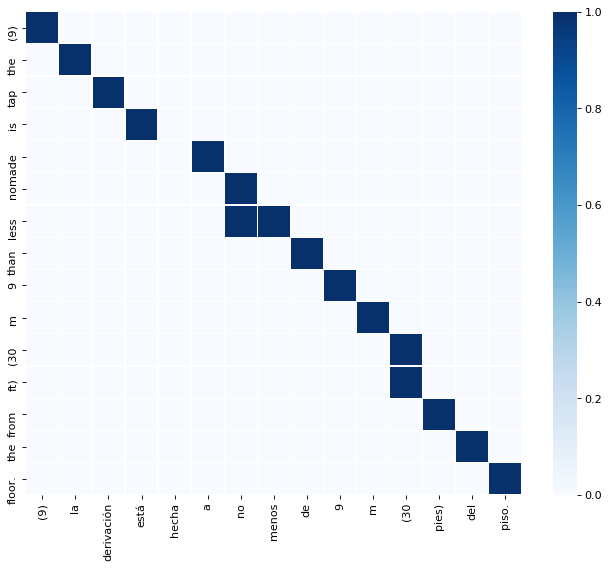

In [152]:
def align_toplot(align_fetched, en_ticks, es_ticks):
    #create alignment matrix
    align_matrix = np.zeros((len(en_ticks), len(es_ticks)))
    for (x,y) in align_fetched:
        align_matrix[x-1,y-1] = 1
    plt.figure(figsize = (10,8), dpi=80)
    sns.heatmap(align_matrix, xticklabels= es_ticks, yticklabels = en_ticks, linewidths=.25,cmap = "Blues", linecolor="White")

align_toplot(align_fetched, en_tk, es_tk)